In [ ]:
# import required libraries
import keras
import keras.utils
# from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers.core import Dropout
from keras.layers import Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l1,l2
from keras.initializers import glorot_uniform

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from keras.models import load_model
import seaborn as sns

In [ ]:
# Importing libraries for DenseNet model
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense, SeparableConv2D, ZeroPadding2D, Add
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, AveragePooling2D, GlobalAvgPool2D, MaxPool2D, MaxPooling2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Reading images from directory: Creating data generator
train = ImageDataGenerator(rescale=1/255)
#validation = ImageDataGenerator(rescale=1/255)
test = ImageDataGenerator(rescale=1/255)

In [ ]:
# Reading all training images: Set target_size=(257,257) so that all read images are of same size and AML images of size(400X400) are resized.
try:
  train_dataset = train.flow_from_directory('/content/drive/MyDrive/Data_New/Train_augmented', target_size = (257,257), batch_size = 32, class_mode = 'categorical', shuffle = True, color_mode = 'rgb')
except FileNotFoundError:
  print("Directory or File does not exist. Check file path")
except:  
  print("Other error")

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 3000 images belonging to 3 classes.


In [ ]:
# Reading all test images. Test data is shuffled: Set target_size=(257,257) so that all read images are of same size and AML images of size(400X400) are resized.
#(If unshuffled: First 130 images are ALL, next 130 are AML and last 130 are Healthy)
try:
  test_data = test.flow_from_directory('/content/drive/MyDrive/Data_New/Test', target_size = (257,257), batch_size = 32, class_mode = 'categorical',classes = ["ALL","AML","Healthy"], shuffle = True, color_mode = 'rgb')
except FileNotFoundError:
  print("Directory or File does not exist. Check file path")
except:  
  print("Other error")

Found 390 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Extracting all Training images in X and y:

In [ ]:
len(train_dataset)

94

In [ ]:
# Extracting all train data in X, y variables by iterating over the batches
train_dataset.reset()
X, y = next(train_dataset) # First batch is fetched now
for i in range(0,93): #1st batch is already fetched before the for loop. length of train_dataset is 94. So running loop till 93.
  img, label = next(train_dataset)
  X = np.append(X, img, axis=0 )
  y = np.append(y, label, axis=0)
print(X.shape, y.shape)

(3000, 257, 257, 3) (3000, 3)


In [ ]:
# Splitting the data into train and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Extracting all test images in X_test and y_test

In [ ]:
len(test_data.filenames)

390

In [ ]:
test_data.class_indices
# test_data.filenames

{'ALL': 0, 'AML': 1, 'Healthy': 2}

In [ ]:
# Storing all test data in variable X_test and respective labels in y_test variable by iterating over the batches
test_data.reset()
X_test, y_test = next(test_data) # First batch is fetched now
for i in range(0,12): #1st batch is already fetched before the for loop. length of test_dataset is 13. So running loop for 12 batches.
  img, label = next(test_data)
  X_test = np.append(X_test, img, axis=0 )
  y_test = np.append(y_test, label, axis=0)
print(X_test.shape, y_test.shape)

(390, 257, 257, 3) (390, 3)


In [ ]:
y_test_classes = [np.argmax(element) for element in y_test]

Creating test data for Xception model
Xception model works only on images with size 299X299 and batch size=16(for memory considerations)

Creating data for xception model

In [ ]:
import cv2

In [ ]:
# Resizing test data images to 299X299 for xception model
X1_test = []

for i in range(0, 390):
    X1_test.append(cv2.resize(X_test[i], (299,299)))

In [ ]:
print(X1_test[1].shape)
print(len(X1_test))

(299, 299, 3)
390


In [ ]:
print(X.shape)

(3000, 257, 257, 3)


In [ ]:
for i in range(390):
  X11 = np.array(X1_test)

In [ ]:
print(X11.shape)
print(type(X11))

(390, 299, 299, 3)
<class 'numpy.ndarray'>


In [ ]:
# Function for Confusion Matrix and Classification report
from sklearn.metrics import confusion_matrix, classification_report
class_labels = list(test_data.class_indices.keys()) # Assigning labels their respective classes

def evaluate_classification_model(y_test, y_pred_test):
    
    target_names = class_labels

    print(classification_report(y_test, y_pred_test, target_names=target_names))


    conf_matrix = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(data=conf_matrix, annot=True, fmt='g', xticklabels=target_names, yticklabels=target_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
#locs,labels = xticks()
    plt.xtickslabels(rotation=90)
    plt.ytickslabels(rotation=90)
    plt.yticks(target_names)
    plt.show()

In [ ]:
# Function for displaying images with their predicted Labels from model
import cv2
def display():
  counter=0   # For counting number of matched images
  counter1=0 # For counting number of unmatched images
  for element in range(0,390):
    #image_path = "/content/drive/MyDrive/Data_New/Test/" + test_data.filenames[element]
    #img = cv2.imread(image_path)
    plt.imshow(X_test[element])
    plt.axis("off")
    
    #for element in y_pred[index]:
    if((y_pred_classes[element] == 0) and (y_pred_classes[element]==y_test_classes[element])):
        plt.title("Matched: ALL")
        counter += 1
    elif((y_pred_classes[element] == 1) and (y_pred_classes[element] == y_test_classes[element])):
        plt.title("Matched: AML")
        counter += 1
    elif((y_pred_classes[element] == 2) and (y_pred_classes[element] == y_test_classes[element])):
        plt.title("Matched: Healthy")
        counter +=1
    elif(((y_pred_classes[element] == 0) and (y_pred_classes[element] != y_test_classes[element]))):
      plt.title("Not Matched: Predicted class is ALL, True class:"+str(y_test_classes[element]))
      counter1 += 1
    elif(((y_pred_classes[element] == 1) and (y_pred_classes[element] != y_test_classes[element]))):
      plt.title("Not Matched:AML,True label:"+str(y_test_classes[element]))
      counter1 += 1
    elif((y_pred_classes[element] == 2) and (y_pred_classes[element] != y_test_classes[element])):
      plt.title("Not Matched:Healthy,True label:"+ str(y_test_classes[element]))
      counter1 += 1
    plt.show()

  print("Number of matched images:",counter)
  print("Number of unmatched images:",counter1)

  # Convert y_test_classes and y_pred_classes into class names and then use in above function. df['Kelas'] = df['Kelas'].map({0:'Elephant',1:'Lion'})

Ensemble Model: Summed

In [ ]:
# Loading all best models: 1. DenseNet 2. ResNet 3. Xception
model1 = load_model('/content/drive/MyDrive/Model_weights/model_dense_89_99.hdf5')
model2 = load_model('/content/drive/MyDrive/Model_weights/model_res_87_98.hdf5')
model3 = load_model('/content/drive/MyDrive/Model_weights/model_xception_87_99.hdf5')

In [ ]:
# As xception model takes different image size and batch size input so we do predictions for xception alone and will concatenate the predictions with other models predictions  
#models = [model1, model2, model3]
models = [model1, model2]

In [ ]:
# Evaluating all best models: 1. DenseNet 2. ResNet 3. Xception
model1.evaluate(X_test, y_test)
model2.evaluate(X_test, y_test)
model3.evaluate(X11, y_test)

13/13 [==============================] - 5s 252ms/step - loss: 0.5324 - accuracy: 0.8744


[0.5324028134346008, 0.8743589520454407]

In [ ]:
# Storing predictions of densenet and resnet50 models in preds
preds = [model.predict(X_test) for model in models]
#preds1 = np.array(preds)
#summed = np.sum(preds, axis = 0)

In [ ]:
# Storing predictions of Xception model tested on X1_test(image size=299X299) in preds_x
preds_x = model3.predict(X11)

In [ ]:
# Adding one more dimension to match the shape of preds_x with preds for joining
preds_xcep = np.expand_dims(preds_x, axis=0)

In [ ]:
#  Converting the list of preds into array
preds1 = np.array(preds)
#summed = np.sum(preds, axis = 0)

In [ ]:
# Concatenating the predictions from all 3 models one below another. Storing in pred
pred = np.vstack((preds1, preds_xcep))

In [ ]:
print(pred.shape) # First dimension: No. of models(dense,resnet,xception), Second dim: No. of images in test data, Third dim: No. of classes-ALL,AML, Healthy

(3, 390, 3)


In [ ]:
print(pred)

[[[8.8961388e-05 9.9991095e-01 6.4787322e-08]
  [9.7407681e-01 2.6072527e-07 2.5923008e-02]
  [6.7776395e-03 1.0052474e-17 9.9322236e-01]
  ...
  [9.9850875e-01 2.5576021e-09 1.4912511e-03]
  [1.4698804e-04 9.9985290e-01 1.6251755e-07]
  [1.2866853e-02 9.8712254e-01 1.0551581e-05]]

 [[1.6356168e-22 1.0000000e+00 5.5043114e-12]
  [9.7313201e-01 1.4783262e-03 2.5389785e-02]
  [4.0326783e-04 1.6384780e-04 9.9943286e-01]
  ...
  [9.9914253e-01 8.5745734e-04 1.7855132e-09]
  [2.3022291e-37 1.0000000e+00 3.9741346e-14]
  [1.0628128e-26 1.0000000e+00 2.4505136e-11]]

 [[7.2729565e-12 1.0000000e+00 4.0051248e-12]
  [9.9839205e-01 1.4982660e-03 1.0964793e-04]
  [4.9015100e-04 8.6879474e-04 9.9864107e-01]
  ...
  [9.9997020e-01 2.9833824e-05 2.1206835e-11]
  [1.0822358e-15 1.0000000e+00 3.9224641e-19]
  [5.8476437e-19 1.0000000e+00 4.7967590e-21]]]


In [ ]:
print(preds1)

[[[8.8961388e-05 9.9991095e-01 6.4787322e-08]
  [9.7407681e-01 2.6072527e-07 2.5923008e-02]
  [6.7776395e-03 1.0052474e-17 9.9322236e-01]
  ...
  [9.9850875e-01 2.5576021e-09 1.4912511e-03]
  [1.4698804e-04 9.9985290e-01 1.6251755e-07]
  [1.2866853e-02 9.8712254e-01 1.0551581e-05]]

 [[1.6356168e-22 1.0000000e+00 5.5043114e-12]
  [9.7313201e-01 1.4783262e-03 2.5389785e-02]
  [4.0326783e-04 1.6384780e-04 9.9943286e-01]
  ...
  [9.9914253e-01 8.5745734e-04 1.7855132e-09]
  [2.3022291e-37 1.0000000e+00 3.9741346e-14]
  [1.0628128e-26 1.0000000e+00 2.4505136e-11]]]


In [ ]:
print(preds_xcep)

[[[7.2729565e-12 1.0000000e+00 4.0051248e-12]
  [9.9839205e-01 1.4982660e-03 1.0964793e-04]
  [4.9015100e-04 8.6879474e-04 9.9864107e-01]
  ...
  [9.9997020e-01 2.9833824e-05 2.1206835e-11]
  [1.0822358e-15 1.0000000e+00 3.9224641e-19]
  [5.8476437e-19 1.0000000e+00 4.7967590e-21]]]


preds1 and preds_xcep are joined correctly in pred

Ensemble: Summed

In [ ]:
# Summing the prediction probability along axis=0 i.e. along first dim: 3(representing predictions from 3 models-dense, resnet and xception). So, probability from each model is added for every class(ALL, AML, Healthy)
summed = np.sum(pred, axis=0)

In [ ]:
# Each column represents each class: ALL,AML,Healthy. The values in each column are sum of probability of occurence of that class from 3 models.
print(summed)

[[8.8961395e-05 2.9999108e+00 6.4796836e-08]
 [2.9456010e+00 2.9768529e-03 5.1422440e-02]
 [7.6710582e-03 1.0326426e-03 2.9912963e+00]
 ...
 [2.9976215e+00 8.8729372e-04 1.4912528e-03]
 [1.4698804e-04 2.9998529e+00 1.6251759e-07]
 [1.2866853e-02 2.9871225e+00 1.0551606e-05]]


In [ ]:
summed.shape

(390, 3)

In [ ]:
# Chosing class with maximum sum of probability(sum of 3 models). Returning column index with maximum sum of probability among classes.
ensemble_prediction = np.argmax(summed, axis = 1)

In [ ]:
print(ensemble_prediction)

[1 0 2 1 0 1 0 0 2 0 0 0 2 0 0 0 1 1 2 0 0 2 1 0 2 0 2 0 1 2 1 2 0 2 1 1 0
 2 2 1 1 1 1 1 0 1 2 0 1 0 2 1 1 2 1 1 0 1 0 2 0 0 2 2 0 2 2 0 0 1 0 2 0 0
 2 1 0 1 2 1 2 0 0 1 0 1 0 0 2 0 1 1 0 0 0 1 0 1 0 1 2 0 0 2 1 1 1 2 0 2 2
 1 0 1 1 1 0 1 0 2 0 0 0 1 1 0 2 1 0 1 0 2 2 2 0 0 1 0 1 2 1 0 1 2 2 0 1 1
 0 1 1 2 1 2 2 0 0 1 2 1 1 0 2 2 1 1 0 1 2 2 0 1 0 1 0 0 0 2 0 1 1 1 1 2 1
 0 0 0 0 2 0 1 1 0 0 0 2 0 0 0 2 0 0 0 0 1 1 0 0 2 2 0 1 2 2 2 2 1 0 1 2 0
 2 2 0 2 0 0 0 0 0 1 1 0 0 2 2 0 2 0 0 0 1 1 1 0 0 2 1 0 1 2 1 2 2 0 2 0 0
 2 2 2 0 1 1 0 0 1 1 0 0 1 0 0 1 0 2 1 0 2 2 0 0 2 2 0 2 0 2 0 2 1 0 1 0 0
 1 0 0 2 0 1 0 2 0 2 1 1 1 2 1 1 2 2 1 1 0 0 2 1 0 2 0 1 2 1 1 1 0 2 0 1 1
 2 0 2 0 0 2 0 2 0 1 0 0 0 1 1 2 1 0 2 2 2 2 2 0 1 0 0 2 2 0 1 1 1 1 1 0 0
 1 0 0 1 0 2 2 0 0 1 1 1 0 1 0 1 1 0 1 1]


In [ ]:
prediction1 = model1.predict(X_test)
prediction2 = model2.predict(X_test)
prediction3 = model3.predict(X11)

In [ ]:
predict1 = [np.argmax(element) for element in prediction1]
predict2 = [np.argmax(element) for element in prediction2]
predict3 = [np.argmax(element) for element in prediction3]

In [ ]:
accuracy1 = accuracy_score(y_test_classes, predict1)
accuracy2 = accuracy_score(y_test_classes, predict2)
accuracy3 = accuracy_score(y_test_classes, predict3) 
ensemble_accuracy = accuracy_score(y_test_classes, ensemble_prediction)

In [ ]:
print(accuracy1)
print(accuracy2)
print(accuracy3)
print(ensemble_accuracy)

0.8871794871794871
0.8743589743589744
0.8743589743589744
0.9102564102564102


 **SUMMED** ensemble model: Confusion Matrix and Classification Report

              precision    recall  f1-score   support

         ALL       0.80      0.98      0.88       130
         AML       1.00      0.98      0.99       130
     Healthy       0.97      0.78      0.86       130

    accuracy                           0.91       390
   macro avg       0.92      0.91      0.91       390
weighted avg       0.92      0.91      0.91       390



AttributeError: ignored

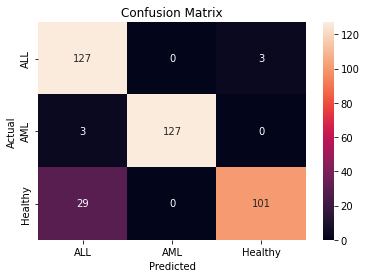

In [ ]:
evaluate_classification_model(y_test_classes, ensemble_prediction)

In [ ]:
"""y_test_classes_labelled = y_test_classes
y_pred_classes_labelled = ensemble_prediction"""

In [ ]:
"""# Converting classes into their respective labels in y_test_classes and y_pred_classes for display
#y_test_classes_labelled = y_test_classes
for i in range(len(y_test_classes_labelled)):
  if y_test_classes_labelled[i] == 0:
    y_test_classes_labelled[i] = 'ALL'
  elif y_test_classes_labelled[i] == 1:
    y_test_classes_labelled[i] = 'AML'
  else:
    y_test_classes_labelled[i] = 'Healthy' """



In [ ]:
"""for i in range(len(y_pred_classes_labelled)):
  if y_pred_classes_labelled[i] == 0:
    y_pred_classes_labelled[i] = 'ALL'
  elif y_pred_classes_labelled[i] == '1':
    y_pred_classes_labelled[i] = 'AML'
  elif (y_pred_classes_labelled[i] == 2):
    y_pred_classes_labelled[i] = 'Healthy'
  else:
    pass """


ValueError: ignored

In [ ]:
y_pred_classes = ensemble_prediction

In [ ]:
# Function for displaying images with their predicted Labels from model
import cv2
def display():
  counter=0   # For counting number of matched images
  counter1=0 # For counting number of unmatched images
  for element in range(0,390):
    #image_path = "/content/drive/MyDrive/Data_New/Test/" + test_data.filenames[element]
    #img = cv2.imread(image_path)
    plt.imshow(X_test[element])
    plt.axis("off")
    
    #for element in y_pred[index]:
    if((y_pred_classes[element] == 0) and (y_pred_classes[element]==y_test_classes[element])):
        plt.title("Matched: ALL")
        counter += 1
    elif((y_pred_classes[element] == 1) and (y_pred_classes[element] == y_test_classes[element])):
        plt.title("Matched: AML")
        counter += 1
    elif((y_pred_classes[element] == 2) and (y_pred_classes[element] == y_test_classes[element])):
        plt.title("Matched: Healthy")
        counter +=1
    elif(((y_pred_classes[element] == 0) and (y_pred_classes[element] != y_test_classes[element]))):
      plt.title("Not Matched: Predicted class is ALL, True class:"+str(y_test_classes[element]))
      counter1 += 1
    elif(((y_pred_classes[element] == 1) and (y_pred_classes[element] != y_test_classes[element]))):
      plt.title("Not Matched:AML,True label:"+str(y_test_classes[element]))
      counter1 += 1
    elif((y_pred_classes[element] == 2) and (y_pred_classes[element] != y_test_classes[element])):
      plt.title("Not Matched:Healthy,True label:"+ str(y_test_classes[element]))
      counter1 += 1
    plt.show()

  print("Number of matched images:",counter)
  print("Number of unmatched images:",counter1)

  # Convert y_test_classes and y_pred_classes into class names and then use in above function. df['Kelas'] = df['Kelas'].map({0:'Elephant',1:'Lion'})

In [ ]:
display()

Output hidden; open in https://colab.research.google.com to view.

The number of matched and unmatched images are confirmed from confusion matrix also. From confusion matrix: No. of Matched images = 127+127+101=355. No. of Unmatched images = 29+3+3=35

Ensemble Model: Weighted Ensemble

In [ ]:
# Assigning weights to each model. As model1 has highest accuracy of 88.72% on test data evaluation so more weight is given to that model.
weights = [0.6,0.2,0.2]

In [ ]:
# Sum of product of all elememts with weights over specified axis. Using tensordot we are doing first multiplication with weights and then doing sum.
weighted_preds = np.tensordot(pred, weights,axes=((0),(0))) 

In [ ]:
weighted_preds.shape 

(390, 3)

In [ ]:
# Returning class index with highest probability among classes
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

In [ ]:
weighted_accuracy = accuracy_score(y_test_classes, weighted_ensemble_prediction)

In [ ]:
print(accuracy1)
print(accuracy2)
print(accuracy3)
print(weighted_accuracy)

0.8871794871794871
0.8743589743589744
0.8743589743589744
0.8871794871794871


**Weighted Ensemble Model**: Confusion Matrix and Classification Report

              precision    recall  f1-score   support

         ALL       0.75      0.99      0.85       130
         AML       1.00      0.99      1.00       130
     Healthy       0.99      0.68      0.80       130

    accuracy                           0.89       390
   macro avg       0.91      0.89      0.88       390
weighted avg       0.91      0.89      0.88       390



AttributeError: ignored

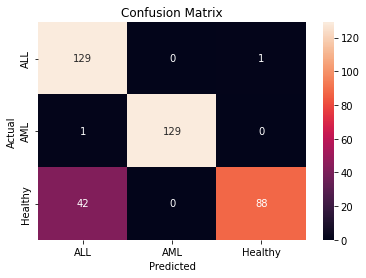

In [ ]:
evaluate_classification_model(y_test_classes, weighted_ensemble_prediction)

In [ ]:
y_pred_classes = weighted_ensemble_prediction

In [ ]:
display()

Output hidden; open in https://colab.research.google.com to view.

The number of matched and unmatched images are confirmed from confusion matrix also. From confusion matrix: No. of Matched images = 127+127+101=355. No. of Unmatched images = 29+3+3=35